In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras
from PIL import Image

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

Using TensorFlow backend.


In [2]:
# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

In [4]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join( 'snapshots', 'resnet50_coco_best_v2.1.0.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}


C:\Users\Yoichi\Anaconda2\envs\tensorflow36\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


processing time:  11.047850370407104


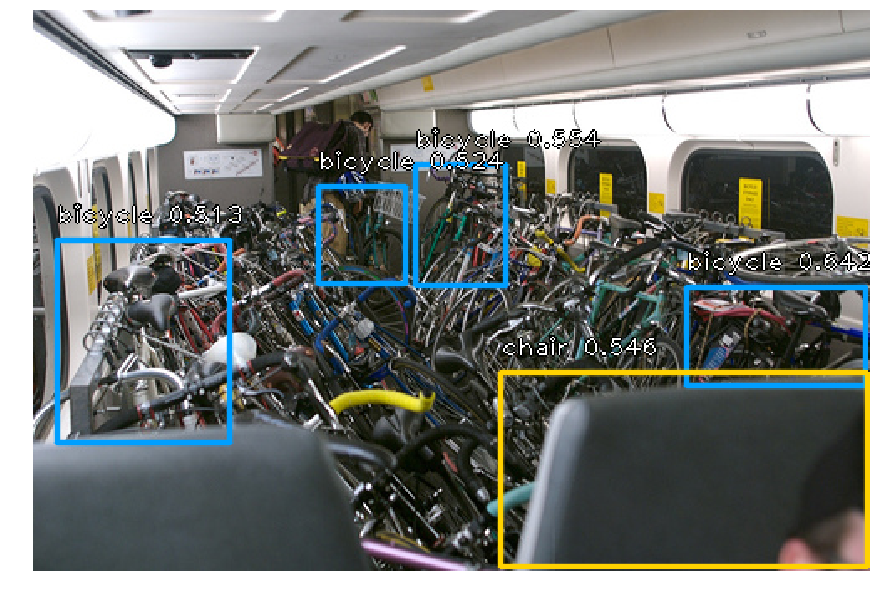

In [99]:
# load image
image = read_image_bgr('Caltrain-Bike-Car-Packed-With-Bikes.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [100]:
unique, counts = np.unique(labels[scores>=.5], return_counts=True)
dict(zip(unique[unique==1], counts[unique==1]))

{1: 4}

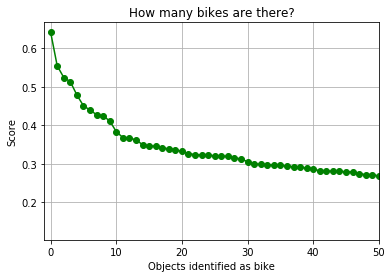

In [101]:
fig, ax = plt.subplots()
ax.plot(scores[labels==1],'go-')


ax.set(xlabel='Objects identified as bike', ylabel='Score',
       title='How many bikes are there?')
ax.grid()
ax.set_xlim([-1, 50])

plt.show()

In [102]:
# automatically find "elbow" aka number of bikes...
curve=scores[labels==1]
nPoints = len(curve)
allCoord = np.vstack((range(nPoints), curve)).T
np.array([range(nPoints), curve])
firstPoint = allCoord[0]
lineVec = allCoord[-1] - allCoord[0]
lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
vecFromFirst = allCoord - firstPoint
scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
vecToLine = vecFromFirst - vecFromFirstParallel
distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
idxOfBestPoint = np.argmax(distToLine)
idxOfBestPoint

31

processing time:  9.6788969039917


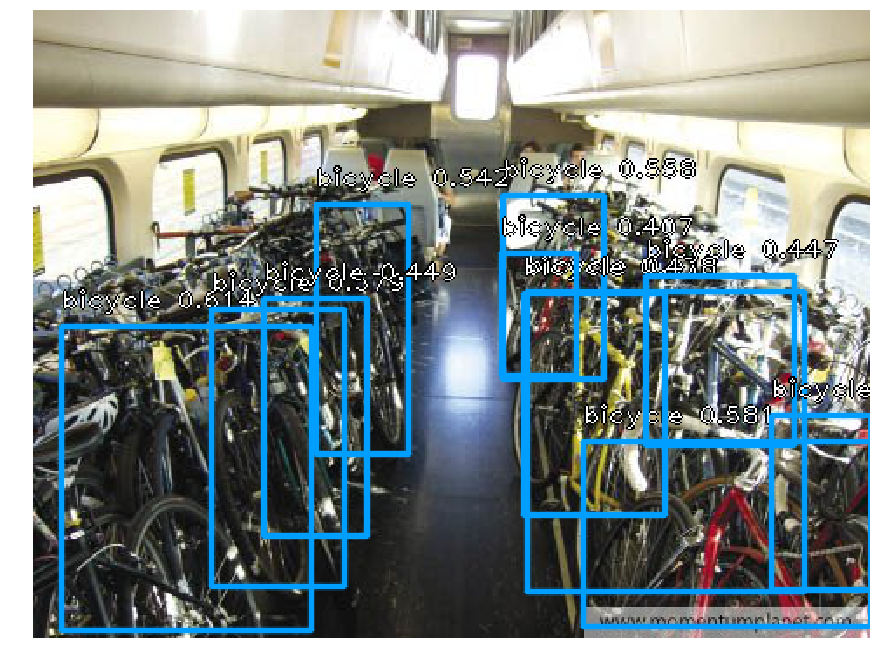

In [103]:
# load image
image = read_image_bgr('Caltrain-train230-bike_opt.jpeg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.4:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

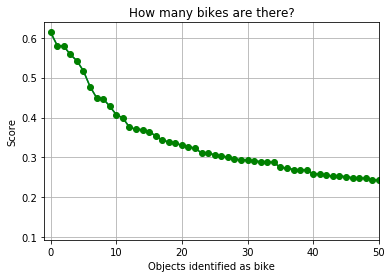

In [104]:
fig, ax = plt.subplots()
ax.plot(scores[labels==1])
ax.plot(scores[labels==1],'go-')


ax.set(xlabel='Objects identified as bike', ylabel='Score',
       title='How many bikes are there?')
ax.grid()
ax.set_xlim([-1, 50])

plt.show()

In [105]:
# automatically find "elbow" aka number of bikes...
curve=scores[labels==1]
nPoints = len(curve)
allCoord = np.vstack((range(nPoints), curve)).T
np.array([range(nPoints), curve])
firstPoint = allCoord[0]
lineVec = allCoord[-1] - allCoord[0]
lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
vecFromFirst = allCoord - firstPoint
scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
vecToLine = vecFromFirst - vecFromFirstParallel
distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
idxOfBestPoint = np.argmax(distToLine)
idxOfBestPoint

40

processing time:  9.675266981124878


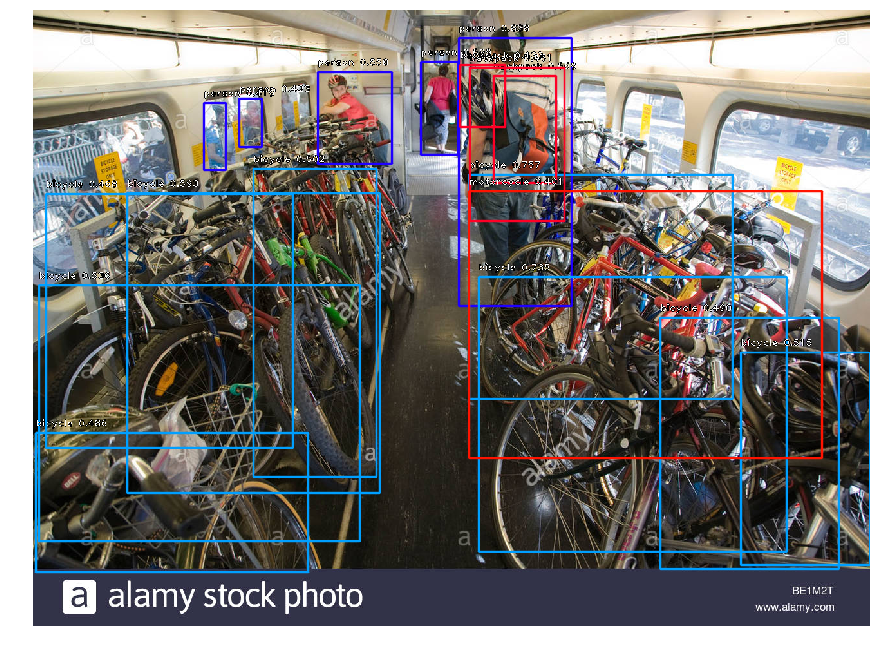

In [93]:
# load image
image = read_image_bgr('BE1M2T.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.4:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [94]:
# automatically find "elbow" aka number of bikes...
curve=scores[labels==1]
nPoints = len(curve)
allCoord = np.vstack((range(nPoints), curve)).T
np.array([range(nPoints), curve])
firstPoint = allCoord[0]
lineVec = allCoord[-1] - allCoord[0]
lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
vecFromFirst = allCoord - firstPoint
scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
vecToLine = vecFromFirst - vecFromFirstParallel
distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
idxOfBestPoint = np.argmax(distToLine)
idxOfBestPoint

23

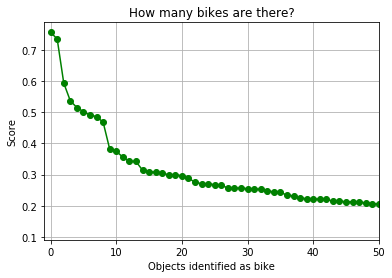

In [98]:
fig, ax = plt.subplots()
ax.plot(scores[labels==1],'go-')


ax.set(xlabel='Objects identified as bike', ylabel='Score',
       title='How many bikes are there?')
ax.grid()
ax.set_xlim([-1, 50])
plt.show()

processing time:  12.030174493789673


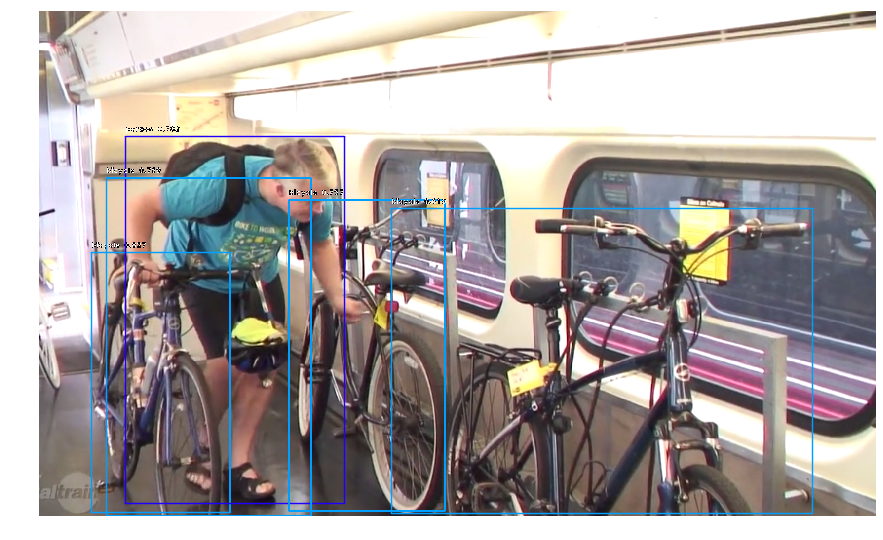

In [91]:
# load image
image = read_image_bgr('BikeRack.png')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [87]:
unique, counts = np.unique(labels[scores>.5], return_counts=True)
dict(zip(unique[unique==1], counts[unique==1]))

{1: 4}

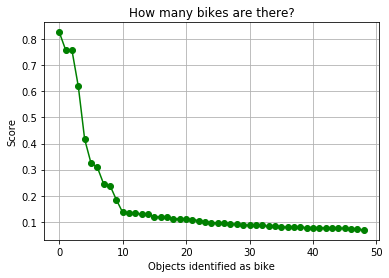

In [88]:
fig, ax = plt.subplots()
ax.plot(scores[labels==1],'go-')


ax.set(xlabel='Objects identified as bike', ylabel='Score',
       title='How many bikes are there?')
ax.grid()

plt.show()

In [89]:
# automatically find "elbow" aka number of bikes...
curve=scores[labels==1]
nPoints = len(curve)
allCoord = np.vstack((range(nPoints), curve)).T
np.array([range(nPoints), curve])
firstPoint = allCoord[0]
lineVec = allCoord[-1] - allCoord[0]
lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
vecFromFirst = allCoord - firstPoint
scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
vecToLine = vecFromFirst - vecFromFirstParallel
distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
idxOfBestPoint = np.argmax(distToLine)
idxOfBestPoint

10